In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
from scipy.optimize import minimize, differential_evolution, line_search, BFGS, SR1, NonlinearConstraint
from numdifftools import Gradient

# Convex optimization

$\begin{align*}
minimize \; f(\boldsymbol{x})&\\
subject \; to \; h(\boldsymbol{x}) &= 0\\
g(\boldsymbol{x}) & \leq 0\\
\boldsymbol{x} & \in \Omega
\end{align*}$

# Unconstrained problem

## Local optima

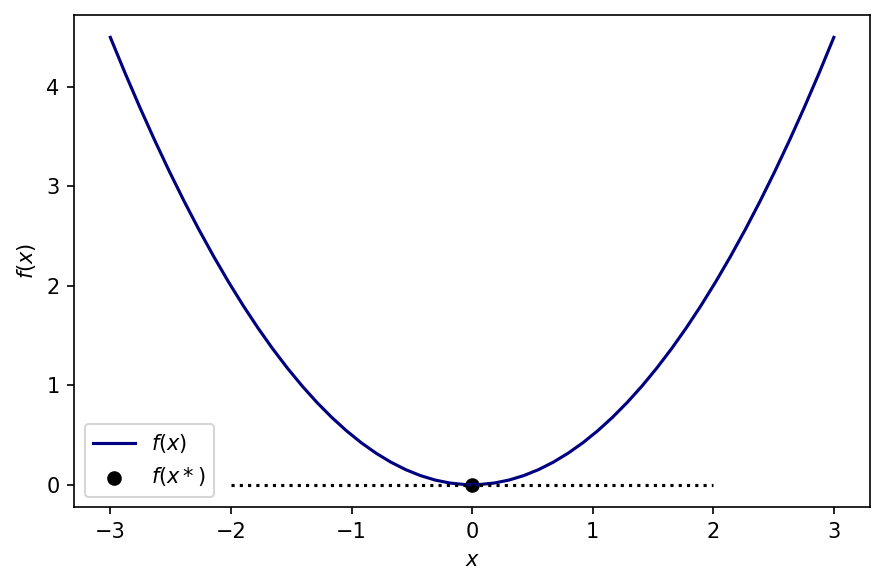

In [2]:
x = np.linspace(-3, 3)
f = lambda x: x ** 2 / 2
slope = lambda x: 2 * x

#Define tangent line
def tan_line(x, x0):
    return slope(x0) * (x - x0) + f(x0)

phi = f(x)

fig, ax = plt.subplots(figsize=[6, 4], dpi=150)

ax.plot(x, phi, color="navy", label=r"$f(x)$")

x0 = np.array([0])
line_x0 = np.array([-2, 2]) + x0
ax.scatter(x0, f(x0), label=r"$f(x*)$", color="black")
ax.plot(line_x0, tan_line(line_x0, x0), color="black", linestyle=":")

ax.legend()

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")

plt.tight_layout()

plt.show()

$f(\boldsymbol{x}) = (x_1 - 0.5)^2 + 0.7 x_1 x_2 + 1.2 (x_1 + 0.7)^2$

In [3]:
#Defining the objective function
def obj_fun(x):

    return (x[0] - 0.5) ** 2 + 0.7 * x[0] * x[1] + 1.2 * (x[1] + 0.7) ** 2

#Defining the gradient function
def gradient_fun(x):
    
    return np.array([2 * (x[0] - 0.5) + 0.7 * x[1], 0.7 * x[0] + 2 * 1.2 * (x[1] + 0.7)])

#Defining the Hessian function
def hess_fun(x):
    
    return np.array([[2., 0.7],
                     [0.7, 2. * 1.2]])

In [4]:
true_optima = - np.linalg.solve(hess_fun([0, 0]), gradient_fun([0, 0]))
print(true_optima)

[ 0.82969838 -0.94199536]


In [5]:
#Creating a countouf plot
n_mesh = 500

x1 = np.linspace(-5, 5, n_mesh)
x2 = np.linspace(-5, 5, n_mesh)

X1, X2 = np.meshgrid(x1, x2)

X = np.vstack((X1.flatten().reshape([1, -1]), X2.flatten().reshape([1, -1])))
F = np.array([obj_fun(x) for x in X.T])

y = F.copy().reshape([n_mesh, n_mesh])

In [6]:
#To work in 3d visuals remove rashtag below
#%matplotlib qt

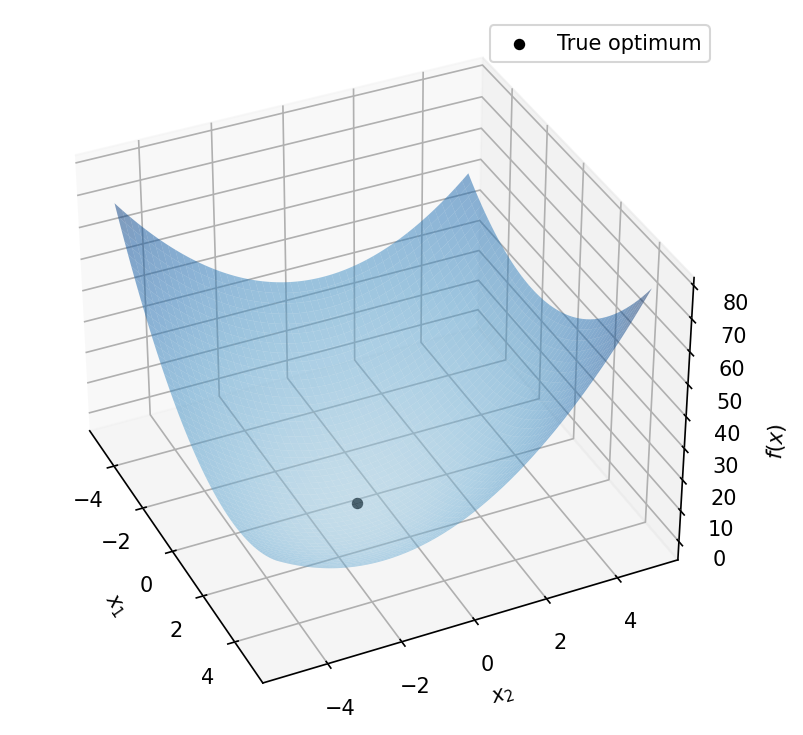

In [7]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150, subplot_kw={"projection": "3d"})

ax.view_init(35, -25)

surf = ax.plot_surface(X1, X2, y, antialiased=True, cmap="Blues", alpha=0.5, vmin=-50, zorder=-1)

ax.scatter([true_optima[0]],  [true_optima[1]], zs=0, marker="o", color="black", label="True optimum", zorder=1)
ax.legend()

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$f(x)$")

plt.tight_layout()

plt.show()

## Line search

**Iteration**

$\boldsymbol{x}_{k+1} = \boldsymbol{x}_{k} + \alpha \boldsymbol{s}_{k}$

**Line search for $\alpha$**

$\phi(\alpha) = f(\boldsymbol{x} + \alpha \boldsymbol{s})$

**Wolfe conditions**

$1) \;\;  \phi(\alpha) \leq \phi(0) + c_1 \alpha \phi'(0)\\$

$2) \;\; |\phi(\alpha)| \leq - c_2 \phi'(0)$


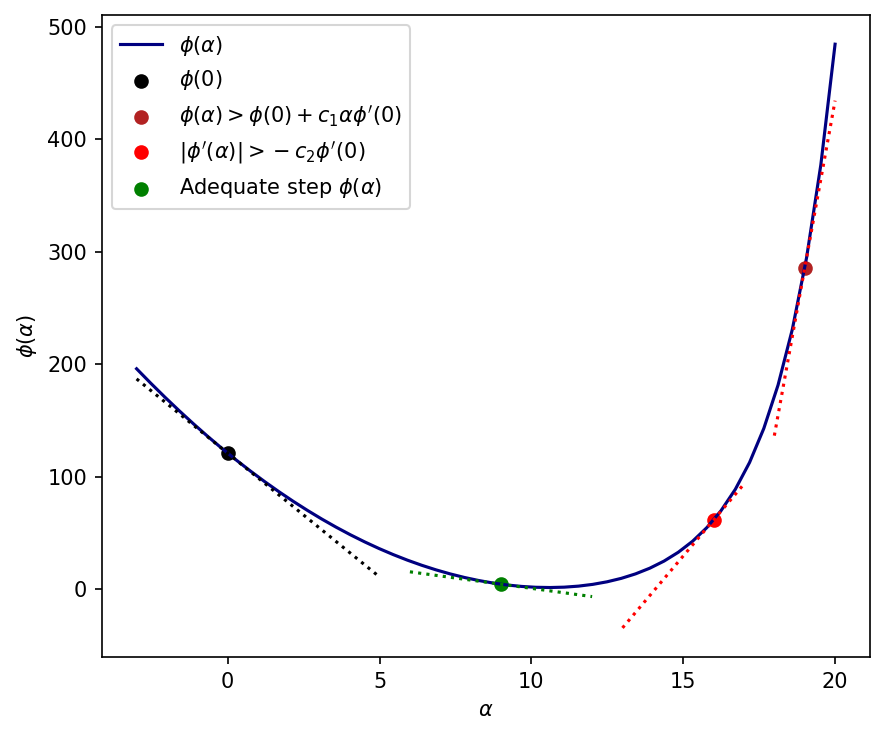

In [8]:
x = np.linspace(-3, 20)
f = lambda x: np.exp((x - 10) * 0.6) + (x - 11) ** 2
slope = lambda x: 0.6 * np.exp((x - 10) * 0.6) + 2 * (x - 11)

#Define tangent line
def tan_line(x, x0):
    return slope(x0) * (x - x0) + f(x0)

phi = f(x)

fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

ax.plot(x, phi, color="navy", label=r"$\phi(\alpha)$")

x0 = np.array([0])
line_x0 = np.array([-3, 5]) + x0
ax.scatter(x0, f(x0), label=r"$\phi(0)$", color="black")
ax.plot(line_x0, tan_line(line_x0, x0), color="black", linestyle=":")

x1 = np.array([19])
line_x1 = np.array([-1, 1]) + x1
ax.scatter(x1, f(x1), label=r"$\phi(\alpha) > \phi(0) + c_1 \alpha \phi'(0)$", color="firebrick")
ax.plot(line_x1, tan_line(line_x1, x1), color="red", linestyle=":")

x2 = np.array([16])
line_x2 = np.array([-3, 1]) + x2
ax.scatter(x2, f(x2), label=r"|$\phi'(\alpha)| > -c_2 \phi'(0)$", color="red")
ax.plot(line_x2, tan_line(line_x2, x2), color="red", linestyle=":")

x3 = np.array([9])
line_x3 = np.array([-3, 3]) + x3
ax.scatter(x3, f(x3), label=r"Adequate step $\phi(\alpha)$", color="green")
ax.plot(line_x3, tan_line(line_x3, x3), color="green", linestyle=":")

ax.legend()

ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\phi(\alpha)$")

plt.tight_layout()

plt.show()

## White label class

In [9]:
class DescentAlgorithm:
    
    def __init__(self, fun, gradient=None, hess=None, nd={}, wolfe_c1=1e-4, wolfe_c2=0.1,
                 x_tol=1e-6, f_tol=1e-6, max_iter=50, save_history=False):
        
        self.fun = fun
        
        if gradient is None:
            self.gradient = Gradient(fun, **nd)
        else:
            self.gradient = gradient
        
        self.hess = hess
        self.wolfe_coefs = wolfe_c1, wolfe_c2
        self.x_tol = x_tol
        self.f_tol = f_tol
        self.max_iter = max_iter
        self.save_history = save_history
        self.history = []
    
    def optimize(self, x0, *args, **kwargs):
        
        x0 = np.atleast_1d(x0).astype(float)
        self.history = []

        xk = x0.copy()
        fk = self.fun(x0, *args, **kwargs)
        gradk = self.gradient(x0, *args, **kwargs)
        
        fc, gc = 1, 1
        
        sk = self.prepare_initial_step(xk, fk, gradk, *args, **kwargs)
        
        advance_x, advance_f, advance_max = True, True, True
        k = 0
        
        if self.save_history:
            self.history.append({"x":xk, "f":fk, "grad":gradk})
        
        while (advance_x or advance_f) and (k <= self.max_iter):
            
            alpha, fc_, gc_, fnew, fk, gradnew = line_search(self.fun, self.gradient,
                                                             xk, sk, gradk, fk, args=args,
                                                             c1=self.wolfe_coefs[0],
                                                             c2=self.wolfe_coefs[1],
                                                             maxiter=15)
            
            if alpha is None:
                alpha = 1
                fnew = self.fun(xk + alpha * sk, *args, **kwargs)
                gradnew = self.gradient(xk + alpha * sk, *args, **kwargs)
            
            xnew = xk + alpha * sk
            fc = fc + fc_
            gc = gc + gc_
            
            if gradnew is None:
                gradnew = self.gradient(xnew)
            
            advance_f = abs(fnew - fk) > self.f_tol
            advance_x = np.linalg.norm(xnew - xk) > self.x_tol
            
            xk, fk, gradk, sk = self.prepare_next_step(xk, fk, gradk, sk, xnew, fnew, gradnew, *args, **kwargs)

            k = k + 1
            
            if self.save_history:
                self.history.append({"x":xk, "f":fk, "grad":gradk})
            
            if np.linalg.norm(sk) < np.sqrt(np.finfo(float).eps):
                self.message = 'Negligible step'
                self.success = True
                break
        
        if not (advance_x or advance_f):
            self.success = True
            self.message = 'Tolerance reached'
            
        elif k > self.max_iter:
            self.success = False
            self.message = 'Max iterations reached'
        
        self.x = xk
        self.f = fk
        self.grad = gradk
        self.fc = fc
        self.gc = gc
        self.result = {"x":xk, "f":fk, "grad":gradk, "iter":k, "message":self.message, "success":self.success}
    
    def prepare_next_step(self, xk, fk, gradk, sk, xnew, fnew, gradnew, *args, **kwargs):
        pass
    
    def prepare_initial_step(self, xk, fk, gradk, *args, **kwargs):
        pass

## Steepest descent

$\boldsymbol{s}_k = -\nabla f(\boldsymbol{x}_k)$

In [10]:
#Common initial estimation to all applied algorithms
x0 = np.array([0, 4])

In [11]:
class SteepestDescent(DescentAlgorithm):

    def prepare_next_step(self, xk, fk, gradk, sk, xnew, fnew, gradnew, *args, **kwargs):
        return xnew, fnew, gradnew, -gradnew
    
    def prepare_initial_step(self, xk, fk, gradk, *args, **kwargs):
        return -gradk

In [12]:
steepest = SteepestDescent(obj_fun, gradient=gradient_fun, save_history=True)
steepest.optimize(x0)
print(steepest.result)

sd_x_hist = np.array([res["x"] for res in steepest.history])
sd_f_hist = np.array([res["f"] for res in steepest.history])

{'x': array([ 0.82969804, -0.94199522]), 'f': -0.368125290023098, 'grad': array([-5.78281692e-07,  9.22860185e-08]), 'iter': 13, 'message': 'Tolerance reached', 'success': True}


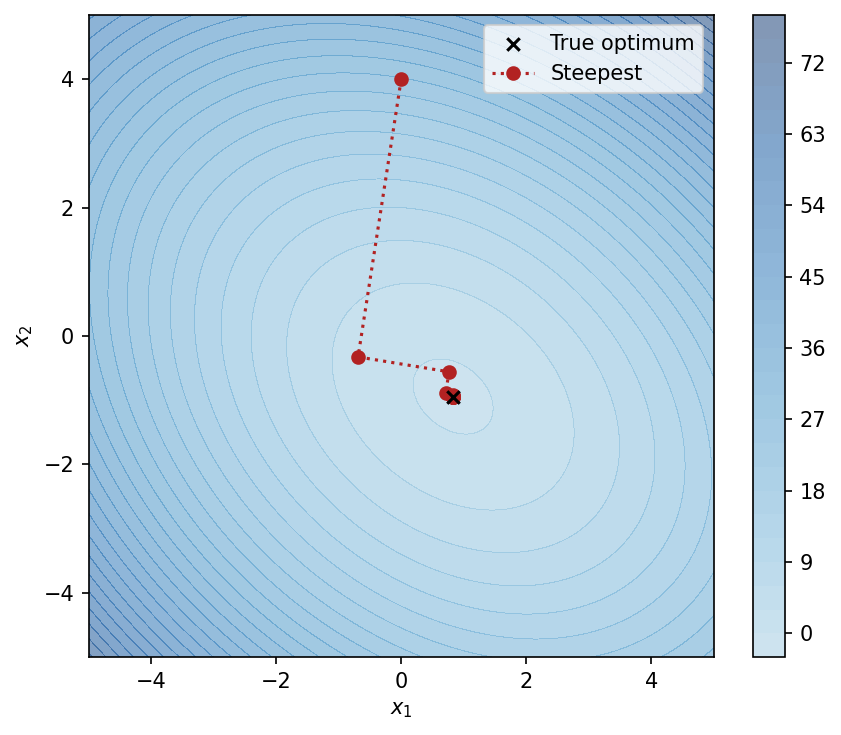

In [13]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, y, antialiased=False, cmap="Blues", alpha=0.5, levels=25, vmin=-50)

ax.scatter([true_optima[0]],  [true_optima[1]], marker="x", color="black", label="True optimum", zorder=10)

ax.plot(sd_x_hist[:, 0], sd_x_hist[:, 1], marker="o", linestyle=":",
        color="firebrick", label="Steepest")

ax.legend()

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

fig.colorbar(surf)

plt.tight_layout()

plt.show()

## Conjugate Gradient

$\boldsymbol{s}_k = -\nabla f(\boldsymbol{x}_k) + \boldsymbol{s}_{k-1} \frac{\nabla f(\boldsymbol{x}_k)^T \nabla f(\boldsymbol{x}_k)}{\nabla f(\boldsymbol{x}_{k-1})^T \nabla f(\boldsymbol{x}_{k-1})}$

In [14]:
class ConjugateGradient(SteepestDescent):

    def prepare_next_step(self, xk, fk, gradk, sk, xnew, fnew, gradnew, *args, **kwargs):
        return xnew, fnew, gradnew, -gradnew + sk * gradnew.dot(gradnew) / gradk.dot(gradk)

In [15]:
cg = ConjugateGradient(obj_fun, gradient=gradient_fun, save_history=True)
cg.optimize(x0)
print(cg.result)

cg_x_hist = np.array([res["x"] for res in cg.history])
cg_f_hist = np.array([res["f"] for res in cg.history])

{'x': array([ 0.82969838, -0.94199536]), 'f': -0.3681252900232017, 'grad': array([-2.22044605e-16, -1.11022302e-16]), 'iter': 2, 'message': 'Negligible step', 'success': True}


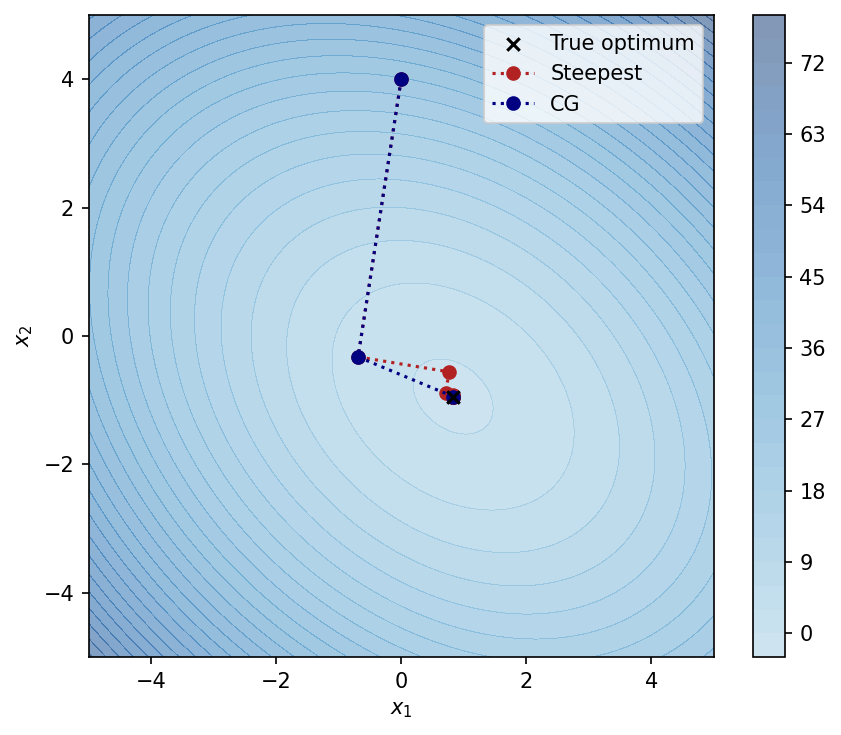

In [16]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, y, antialiased=False, cmap="Blues", alpha=0.5, levels=25, vmin=-50)

ax.scatter([true_optima[0]],  [true_optima[1]], marker="x", color="black", label="True optimum", zorder=10)

ax.plot(sd_x_hist[:, 0], sd_x_hist[:, 1], marker="o", linestyle=":",
        color="firebrick", label="Steepest")

ax.plot(cg_x_hist[:, 0], cg_x_hist[:, 1], marker="o", linestyle=":",
        color="navy", label="CG")

ax.legend()

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

fig.colorbar(surf)

plt.tight_layout()

plt.show()

## Newton

**Taylor Series**

$f(\boldsymbol{x}) \simeq f(\boldsymbol{x}_k) + \nabla f(\boldsymbol{x}_k)(\boldsymbol{x} - \boldsymbol{x}_k) + \frac{1}{2}(\boldsymbol{x} - \boldsymbol{x}_k)^T \nabla^2 f(\boldsymbol{x}_k)(\boldsymbol{x} - \boldsymbol{x}_k)$


**Search directions**

$\boldsymbol{s}_k = -\nabla^2 f(\boldsymbol{x}_k)^{-1} \nabla f(\boldsymbol{x}_k)$

In [17]:
class Newton(DescentAlgorithm):
    
    def __init__(self, fun, gradient=None, hess=None, nd={}, wolfe_c1=1e-4, wolfe_c2=0.9,
                 x_tol=1e-6, f_tol=1e-6, max_iter=50, save_history=False):
        
        if hess is None:
            raise TypeError("Must provide hessian")
        
        super().__init__(fun, gradient=gradient, hess=hess, nd=nd, wolfe_c1=wolfe_c1, wolfe_c2=wolfe_c2,
                         x_tol=x_tol, f_tol=f_tol, max_iter=max_iter, save_history=save_history)
    
    def prepare_next_step(self, xk, fk, gradk, sk, xnew, fnew, gradnew, *args, **kwargs):
        H = self.hess(xnew, *args, **kwargs)
        return xnew, fnew, gradnew, np.linalg.solve(H, -gradnew)
    
    def prepare_initial_step(self, xk, fk, gradk, *args, **kwargs):
        H = self.hess(xk, *args, **kwargs)
        return np.linalg.solve(H, -gradk)

In [18]:
newton = Newton(obj_fun, gradient=gradient_fun, hess=hess_fun, save_history=True)
newton.optimize(x0)
print(newton.result)

newton_x_hist = np.array([res["x"] for res in newton.history])
newton_f_hist = np.array([res["f"] for res in newton.history])

{'x': array([ 0.82969838, -0.94199536]), 'f': -0.3681252900232018, 'grad': array([-1.11022302e-16,  9.99200722e-16]), 'iter': 1, 'message': 'Negligible step', 'success': True}


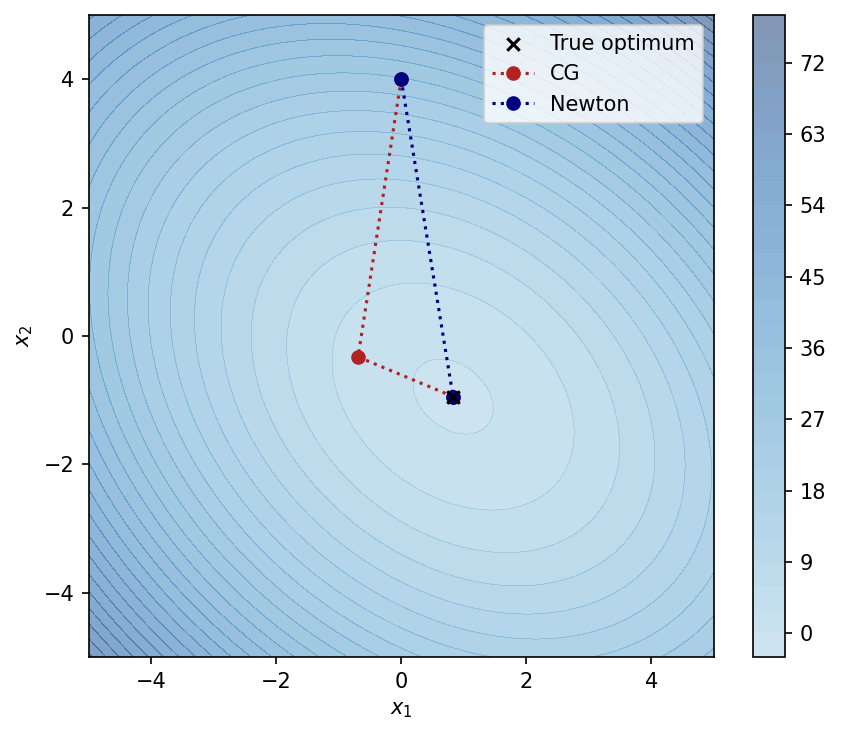

In [19]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, y, antialiased=False, cmap="Blues", alpha=0.5, levels=25, vmin=-50)

ax.scatter([true_optima[0]],  [true_optima[1]], marker="x", color="black", label="True optimum", zorder=10)

ax.plot(cg_x_hist[:, 0], cg_x_hist[:, 1], marker="o", linestyle=":",
        color="firebrick", label="CG")

ax.plot(newton_x_hist[:, 0], newton_x_hist[:, 1], marker="o", linestyle=":",
        color="navy", label="Newton")

ax.legend()

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

fig.colorbar(surf)

plt.tight_layout()

plt.show()

## Quasi-Newton

**General seach direction**:

$\boldsymbol{s}_k = -B_k^{-1} \nabla f(\boldsymbol{x}_k)$

**Difference vectors**:

$\boldsymbol{d}_k = \boldsymbol{x}_{k + 1} - \boldsymbol{x}_{k}$

$\boldsymbol{y}_k = \nabla f(\boldsymbol{x}_{k + 1}) - \nabla f(\boldsymbol{x}_k)$

**BFGS**:

$B_{k+1} = B_k - \frac{B_k \boldsymbol{d}_k \boldsymbol{d}_k^T B_k}{\boldsymbol{d}_k^T B_k \boldsymbol{d}_k} + \frac{\boldsymbol{y}_k \boldsymbol{y}_k^T}{\boldsymbol{y}_k^T \boldsymbol{d}_k}$

**SR1**:

$B_{k+1} = B_k + \frac{(\boldsymbol{y}_k - B_k \boldsymbol{d}_k) (\boldsymbol{y}_k - B_k \boldsymbol{d}_k)^T}{(\boldsymbol{y}_k - B_k \boldsymbol{d}_k)^T \boldsymbol{d}_k}$

In [20]:
class QuasiNewton(Newton):

    def __init__(self, fun, gradient=None, hess=None, nd={}, wolfe_c1=1e-4, wolfe_c2=0.9,
                 x_tol=1e-6, f_tol=1e-6, max_iter=50, save_history=False):
        
        if hess is None:
            hess = BFGS(exception_strategy="damp_update", min_curvature=0.2)
        
        super().__init__(fun, gradient=gradient, hess=hess, nd=nd, wolfe_c1=wolfe_c1, wolfe_c2=wolfe_c2,
                         x_tol=x_tol, f_tol=f_tol, max_iter=max_iter, save_history=save_history)
    
    def prepare_next_step(self, xk, fk, gradk, sk, xnew, fnew, gradnew, *args, **kwargs):
        self.hess.update(xnew - xk, gradnew - gradk)
        H = self.hess.get_matrix()
        return xnew, fnew, gradnew, np.linalg.solve(H, -gradnew)
    
    def prepare_initial_step(self, xk, fk, gradk, *args, **kwargs):
        self.hess.initialize(xk.shape[0], "hess")
        H = self.hess.get_matrix()
        return np.linalg.solve(H, -gradk)

In [21]:
bfgs_high_c2 = QuasiNewton(obj_fun, gradient=gradient_fun, save_history=True)
bfgs_high_c2.optimize(x0)
print(bfgs_high_c2.result)

bfgs_x_hist_high = np.array([res["x"] for res in bfgs_high_c2.history])
bfgs_f_hist_high = np.array([res["f"] for res in bfgs_high_c2.history])

{'x': array([ 0.82969838, -0.94199536]), 'f': -0.3681252900232018, 'grad': array([-5.55111512e-16,  0.00000000e+00]), 'iter': 3, 'message': 'Negligible step', 'success': True}


In [22]:
bfgs = QuasiNewton(obj_fun, gradient=gradient_fun, wolfe_c2=0.1, save_history=True)
bfgs.optimize(x0)
print(bfgs.result)

bfgs_x_hist = np.array([res["x"] for res in bfgs.history])
bfgs_f_hist = np.array([res["f"] for res in bfgs.history])

{'x': array([ 0.82969838, -0.94199536]), 'f': -0.36812529002320177, 'grad': array([-3.33066907e-16, -3.33066907e-16]), 'iter': 2, 'message': 'Negligible step', 'success': True}


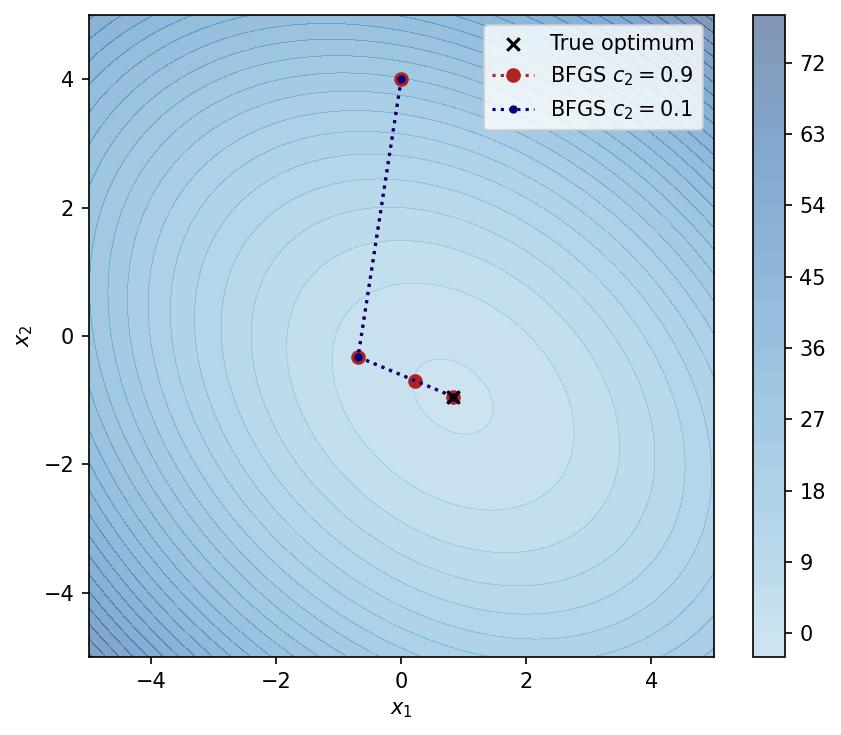

In [23]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, y, antialiased=False, cmap="Blues", alpha=0.5, levels=25, vmin=-50)

ax.scatter([true_optima[0]],  [true_optima[1]], marker="x", color="black", label="True optimum", zorder=10)

ax.plot(bfgs_x_hist_high[:, 0], bfgs_x_hist_high[:, 1], marker="o", linestyle=":",
        color="firebrick", label=r"BFGS $c_2 = 0.9$")

ax.plot(bfgs_x_hist[:, 0], bfgs_x_hist[:, 1], marker=".", linestyle=":",
        color="navy", label=r"BFGS $c_2 = 0.1$")

ax.legend()

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

fig.colorbar(surf)

plt.tight_layout()

plt.show()

In [24]:
sr1 = QuasiNewton(obj_fun, gradient=gradient_fun, hess=SR1(init_scale="auto"), save_history=True)
sr1.optimize(x0)
print(sr1.result)

{'x': array([ 0.82969838, -0.94199536]), 'f': -0.36812529002320177, 'grad': array([0., 0.]), 'iter': 4, 'message': 'Negligible step', 'success': True}


c:\Users\Bruno\OneDrive\Área de Trabalho\Python Packages\mooscalia\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


In [25]:
sr1 = QuasiNewton(obj_fun, gradient=gradient_fun, hess=SR1(init_scale="auto"), wolfe_c2=0.1, save_history=True)
sr1.optimize(x0)
print(sr1.result)

{'x': array([ 0.82969838, -0.94199536]), 'f': -0.36812529002320177, 'grad': array([0., 0.]), 'iter': 4, 'message': 'Negligible step', 'success': True}


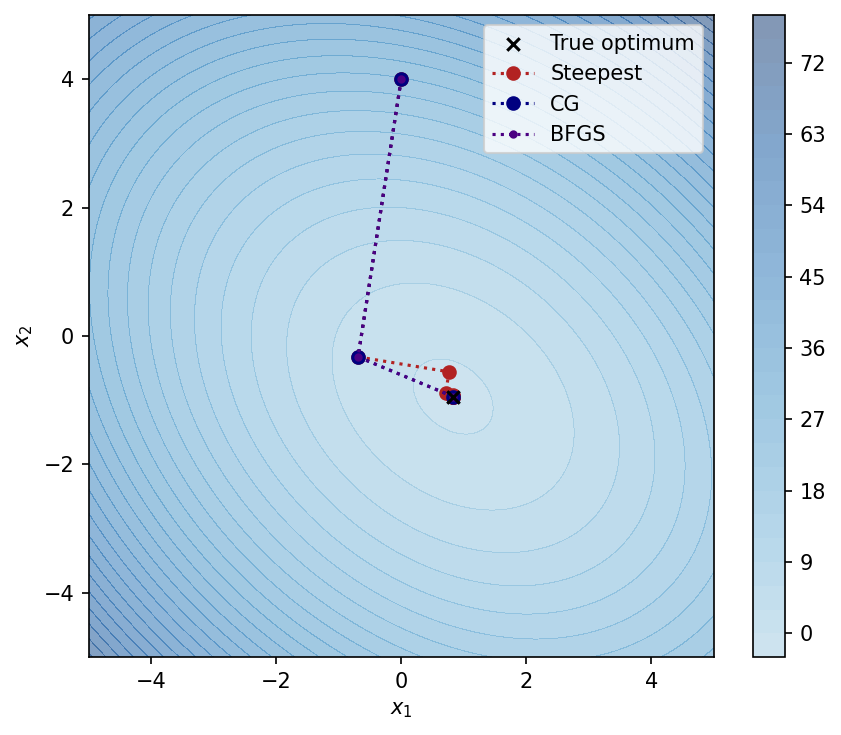

In [26]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, y, antialiased=False, cmap="Blues", alpha=0.5, levels=25, vmin=-50)

ax.scatter([true_optima[0]],  [true_optima[1]], marker="x", color="black", label="True optimum", zorder=10)

ax.plot(sd_x_hist[:, 0], sd_x_hist[:, 1], marker="o", linestyle=":",
        color="firebrick", label="Steepest")

ax.plot(cg_x_hist[:, 0], cg_x_hist[:, 1], marker="o", linestyle=":",
        color="navy", label="CG")

ax.plot(bfgs_x_hist[:, 0], bfgs_x_hist[:, 1], marker=".", linestyle=":",
        color="indigo", label="BFGS")
ax.legend()

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

fig.colorbar(surf)

plt.tight_layout()

plt.show()

# Constrained

**Conditions in feasible tangent plane**

$\nabla \boldsymbol{h}(\boldsymbol{x}^*)\boldsymbol{y}=0$

$\nabla f(\boldsymbol{x}^*)\boldsymbol{y}=0$


**Lagrangian function**

$\mathcal{L}(\boldsymbol{x}, \boldsymbol{\lambda}, \boldsymbol{\mu}) = f(\boldsymbol{x}) + \boldsymbol{\lambda}^T \boldsymbol{h}(\boldsymbol{x}) + \boldsymbol{\mu}^T \boldsymbol{g}(\boldsymbol{x})$

**Complementary slackness**

$\boldsymbol{\mu}^T \boldsymbol{g}(\boldsymbol{x}) = 0$

$\boldsymbol{\mu}^T \geq 0$

**First order conditions (KKT)**

$\nabla \mathcal{L}(\boldsymbol{x}^*, \boldsymbol{\lambda}, \boldsymbol{\mu}) = 0$

**Second order conditions**

$\boldsymbol{s}^T \nabla ^2 \mathcal{L}(\boldsymbol{x}^*, \boldsymbol{\lambda}, \boldsymbol{\mu}) \boldsymbol{s} \geq 0$

scipy standard form:

$g(x) \geq 0$

Constraint of the example:

$x_1^2 + x_2^2 - 3 \geq 0$

In [27]:
#The constraint is a circle of squared radius 3 and center in zero
def cons_fun(x):
    
    return (x ** 2).sum() - 3

#The constraint gradient
def cons_grad(x):
    
    return 2 * np.array(x)

In [28]:
#A decent but infeasible initial estimation
sol_cons = minimize(obj_fun, [0., 0.], jac=gradient_fun,
                    constraints={"type":"ineq", "fun":cons_fun, "grad":cons_grad},
                    method="SLSQP")

print(sol_cons)

     fun: -0.19794737690367115
     jac: array([ 0.48813056, -0.51961018])
 message: 'Optimization terminated successfully'
    nfev: 7
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([ 1.18590266, -1.26239252])


In [29]:
#A very poor initial estimation oposite to the central hole
sol_cons = minimize(obj_fun, x0, jac=gradient_fun,
                    constraints={"type":"ineq", "fun":cons_fun, "grad":cons_grad},
                    method="SLSQP")

print(sol_cons)

     fun: -0.19794737132202567
     jac: array([ 0.48814472, -0.51959446])
 message: 'Optimization terminated successfully'
    nfev: 22
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([ 1.18590799, -1.26238752])


In [30]:
#Creating a countouf plot
n_mesh = 500

x1 = np.linspace(-5, 5, n_mesh)
x2 = np.linspace(-5, 5, n_mesh)

X1, X2 = np.meshgrid(x1, x2)

X = np.vstack((X1.flatten().reshape([1, -1]), X2.flatten().reshape([1, -1])))
F = np.array([obj_fun(x) for x in X.T])
G = np.array([cons_fun(x) for x in X.T])

y_cons = F.copy()
#y_cons[G < 0] = np.nan

y_cons = y_cons.reshape([n_mesh, n_mesh])

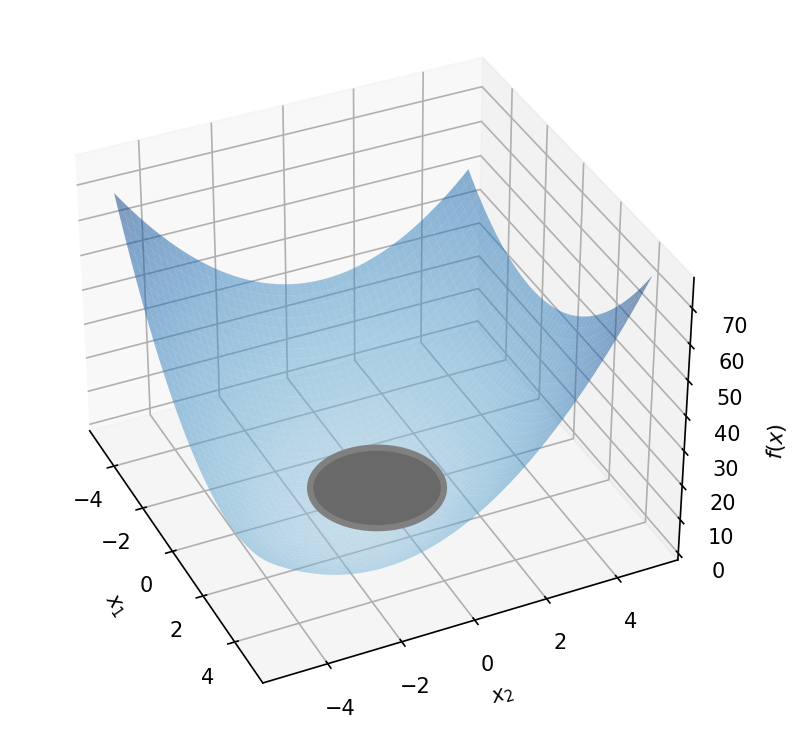

In [31]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150, subplot_kw={"projection": "3d"})

ax.view_init(35, -25)
ax.computed_zorder = False

surf = ax.plot_surface(X1, X2, y_cons, antialiased=True, cmap="Blues", alpha=0.5, vmin=-50, zorder=0)
circle = plt.Circle((0, 0), np.sqrt(3), facecolor='dimgrey', edgecolor="grey", linewidth=3, alpha=1.0, zorder=1)
ax.add_patch(circle)
art3d.pathpatch_2d_to_3d(circle, z=0, zdir="z")

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$f(x)$")

plt.tight_layout()

plt.show()

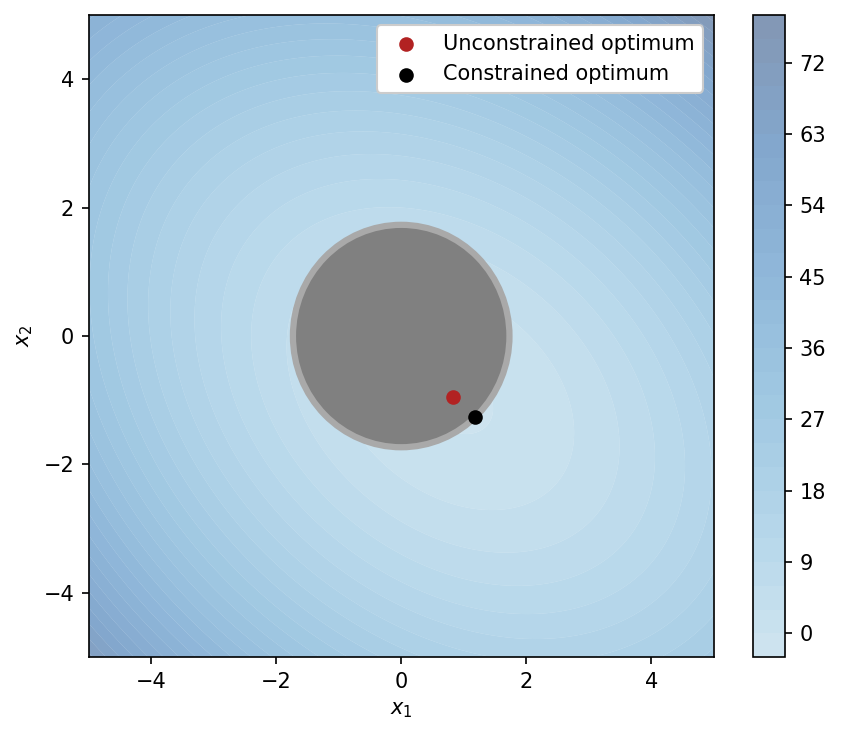

In [32]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, y_cons, antialiased=True, cmap="Blues", alpha=0.5, levels=25, vmin=-50)

circle = plt.Circle((0, 0), np.sqrt(3), facecolor='grey', edgecolor="darkgrey", linewidth=3, alpha=1.0, zorder=1)
ax.add_patch(circle)

ax.scatter([true_optima[0]],  [true_optima[1]], marker="o", color="firebrick", label="Unconstrained optimum", zorder=2)
ax.scatter([sol_cons.x[0]],  [sol_cons.x[1]], marker="o", color="black", label="Constrained optimum", zorder=3)
ax.legend(framealpha=1)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

fig.colorbar(surf)

plt.tight_layout()

plt.show()

## Differential Evolution: An alternative to convex optimization

In [33]:
#Create contraint object
constraint = NonlinearConstraint(cons_fun, 0, np.inf, jac=cons_grad)

#Implementation of DE: popsize, maxiter, strategy, recombination, and mutation are the most important DE parameters
sol_de = differential_evolution(obj_fun, bounds=[(-5, 5), (-5, 5)], constraints=constraint,
                                strategy="rand1bin", mutation=(0.3, 1.0), recombination=0.8, 
                                popsize=20, maxiter=40)

print(sol_de)

           constr: [array([0.])]
 constr_violation: 0.0
              fun: -0.1979473667788621
              jac: [array([[ 2.37180356, -2.52478674]]), array([[1., 0.],
       [0., 1.]])]
            maxcv: 0.0
          message: 'Optimization terminated successfully.'
             nfev: 1126
              nit: 31
          success: True
                x: array([ 1.18590178, -1.26239337])


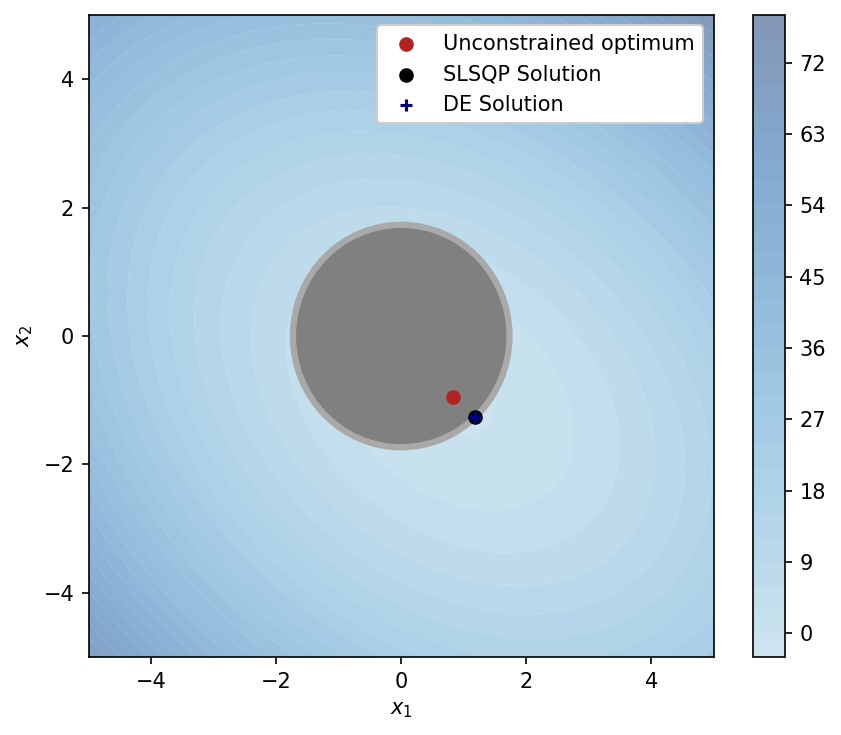

In [34]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, y_cons, antialiased=True, cmap="Blues", alpha=0.5, levels=25, vmin=-50)

circle = plt.Circle((0, 0), np.sqrt(3), facecolor='grey', edgecolor="darkgrey", linewidth=3, alpha=1.0, zorder=1)
ax.add_patch(circle)

ax.scatter([true_optima[0]],  [true_optima[1]], marker="o", color="firebrick", label="Unconstrained optimum", zorder=2)
ax.scatter([sol_cons.x[0]],  [sol_cons.x[1]], marker="o", color="black", label="SLSQP Solution", zorder=3)
ax.scatter([sol_de.x[0]],  [sol_de.x[1]], marker="+", color="navy", label="DE Solution", zorder=3)
ax.legend(framealpha=1)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

fig.colorbar(surf)

plt.tight_layout()

plt.show()